---
title: Floating Point Arithmetics
order: 2
---

This is a topic that breaks my head each time I try to understand it. This is a summary of what I know and what I don't.

## Purpose
Floating point is a way to represent scientific notation in a computer. Its purpose is to be able to represent both values that are very very small and values that are very very big.

## Internal representation
Internal representation is a tripplet of sign, exponent and a significand (also called fraction or mantissa, represents the significant digits). On most current computers, the used standard is called IEEE 754. Its double-precision format, "binary64", has 1 bit for the sign, 11 bits for the exponent and 53 bits for the significand.

## Normalization
Since there are possibly many ways to decompose a number into such triplet (for example, the number 12 can be represented by either $12 \times 2^0$, $3 \times 2^2$ or $1.5 \times 2^3$), the numbers are stored in a *normalized form*. That means that the significand represents digits after a decimal point after a $1$. So each floating point number is represented as $(-1)^{sign} \times 1.fraction \times 2^{exponent}$. The purpose of this normalization is to maximize efficiency and precision.

## Not every number is representable
Since the significand has a finite number of bits available, some numbers are simply not representable. Famously, the number $0.1$ is not perfectly representable, because in base 2 one would need infinite digits of the significand to represent it perfectly. It is similar to the number $\frac{1}{3}$ not being perfectly representable in base 10 with finite number of significant digits. For example, with 5 significant (decimal) digits, the best you could do is to represent $\frac{1}{3}$ by $0.33333$.

## Rounding
When this happens (the number entered is not perfectly representable), the floating point standard performs *rounding*. It represents the entered number as a close representable number. The direction of rounding can be either toward zero, to the nearest representable number, toward positive infinity or toward negative infinity. So, the code `0.1 + 0.1 + 0.1 == 0.3` evaluates to `False`, because the addition on the left-hand side is rounded to a different number than what the number 0.3 is represented with.

In [1]:
print(f"{0.1+0.1+0.1:.60f}")

print(f"{0.3:.60f}")

0.300000000000000044408920985006261616945266723632812500000000
0.299999999999999988897769753748434595763683319091796875000000


## `sys.float_info`
In Python, the parameters of floating point arithmetics on a particular machine can be found using the attribute `float_info` of the module `sys`. See the [docs](https://docs.python.org/3/library/sys.html). For example, we can see that the rounding mode on my computer is "toward nearest".

In [2]:
import sys

print(sys.float_info)

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


Notice the value `dig`, "the maximum number of decimal digits that can be faithfully represented in a float". To me, it is surprisingly small. On my computer, any number that has 15 or less significant digits, can be converted from `str` to `float` and back without change of value. But numbers with more than 15 significant digits aren't guarranteed to have this property:

In [3]:
s = "3.14159265358979"
print(s)
print(f"{float(s):.60}")
print(str(float(s)))
print("----------")
s = "0.000000314159265358979"
print(s)
print(f"{float(s):.60}")
print(str(float(s)))

3.14159265358979
3.141592653589790007373494518105871975421905517578125
3.14159265358979
----------
0.000000314159265358979
3.14159265358979004489366594968235979479231900768354535102844e-07
3.14159265358979e-07


In [4]:
s = "9.876543210123459"
print(s)
print(f"{float(s):.60}")
print(str(float(s)))

9.876543210123459
9.8765432101234598150085730594582855701446533203125
9.87654321012346


## Accumulation of rounding error

Let's look at this code:

In [5]:
x = 0
for _ in range(10):
    x += 0.1
    print(f"{x:.55f}")

0.1000000000000000055511151231257827021181583404541015625
0.2000000000000000111022302462515654042363166809082031250
0.3000000000000000444089209850062616169452667236328125000
0.4000000000000000222044604925031308084726333618164062500
0.5000000000000000000000000000000000000000000000000000000
0.5999999999999999777955395074968691915273666381835937500
0.6999999999999999555910790149937383830547332763671875000
0.7999999999999999333866185224906075745820999145507812500
0.8999999999999999111821580299874767661094665527343750000
0.9999999999999998889776975374843459576368331909179687500


The rounding errors are sometimes positive, sometimes negative. All in all, I think they are basicaly random. But they can accumulate over a large amount of operations. This code should test this.

To explain this code: It is obviously impossible to measure the rounding error of numbers that aren't perfectly representable, like 0.1. Because I can't represent the actual value to compare the floating point number with. But integers up to 10^`sys.float_info[max_10_exp]` are perfectly representable. I'm using this fact and measuring the rounding error after each 10th iteration.

In [6]:
from matplotlib import pyplot as plt
import numpy as np

In [7]:
w, x, y, z = 0, 0, 0, 0
errors_1, errors_3, errors_7, errors_9 = [], [], [], []
for i in range(1, 1_000_001):
    w += 0.1
    x += 0.3
    y += 0.7
    z += 0.9
    if i != 1 and i % 10 == 0:
        errors_1.append(w - i * 0.1)
        errors_3.append(x - i * 0.3)
        errors_7.append(y - i * 0.7)
        errors_9.append(z - i * 0.9)

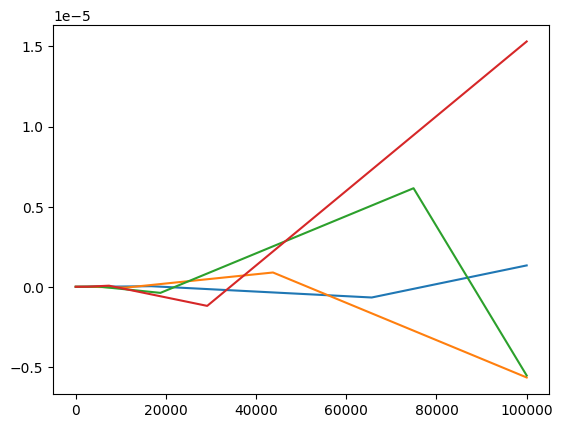

In [8]:
plt.plot(errors_1)
plt.plot(errors_3)
plt.plot(errors_7)
plt.plot(errors_9)

C:\Users\marti\AppData\Local\Temp\ipykernel_7900\2778079877.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(np.array(errors_1))))
C:\Users\marti\AppData\Local\Temp\ipykernel_7900\2778079877.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(np.array(errors_3))))
C:\Users\marti\AppData\Local\Temp\ipykernel_7900\2778079877.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(np.array(errors_7))))
C:\Users\marti\AppData\Local\Temp\ipykernel_7900\2778079877.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.abs(np.array(errors_9))))


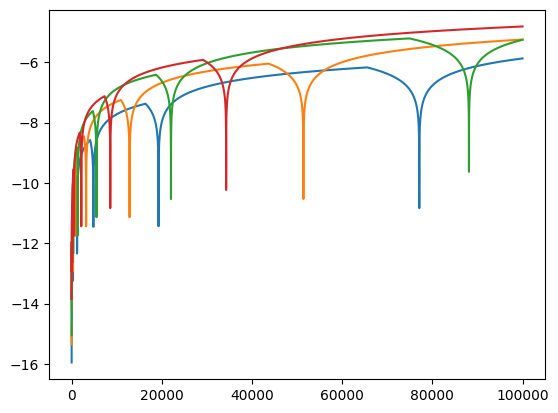

In [9]:
plt.plot(np.log10(np.abs(np.array(errors_1))))
plt.plot(np.log10(np.abs(np.array(errors_3))))
plt.plot(np.log10(np.abs(np.array(errors_7))))
plt.plot(np.log10(np.abs(np.array(errors_9))))

We can see the the magnitude of the error always fluctuates around zero, and sometimes is exactly zero (hence the errors `RuntimeWarning: divide by zero encountered in log10`), but the magnitude of this fluctuation generally increases with increasing number of floating point operations.

However, the situation is a bit different when applied to subtracting. The errors are always in the same direction and their increase in magnitude is a bit questionable. So I'm actually confused.

In [10]:
num_iters = 1_000_000
w, x, y, z = (
    int(num_iters * 0.1),
    int(num_iters * 0.3),
    int(num_iters * 0.7),
    int(num_iters * 0.9),
)
errors_1, errors_3, errors_7, errors_9 = [], [], [], []
for i in range(1, num_iters + 1):
    w -= 0.1
    x -= 0.3
    y -= 0.7
    z -= 0.9
    if i != 1 and i % 10 == 0:
        errors_1.append(w - (int(num_iters * 0.1) - i * 0.1))
        errors_3.append(x - (int(num_iters * 0.3) - i * 0.3))
        errors_7.append(y - (int(num_iters * 0.7) - i * 0.7))
        errors_9.append(z - (int(num_iters * 0.9) - i * 0.9))

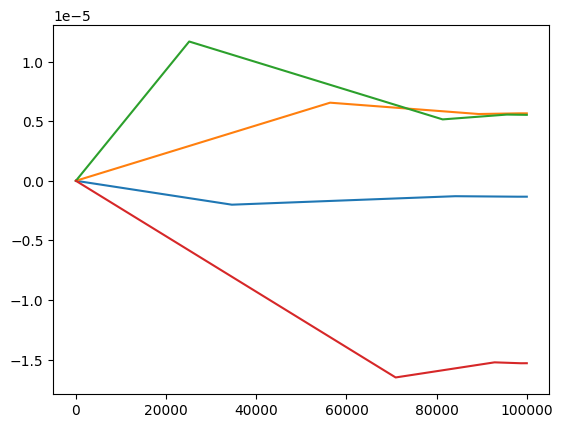

In [11]:
plt.plot(errors_1)
plt.plot(errors_3)
plt.plot(errors_7)
plt.plot(errors_9)

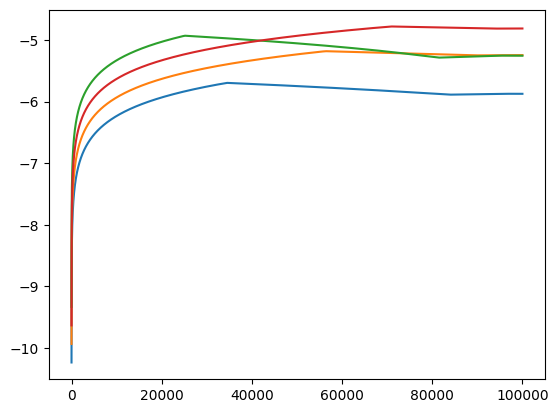

In [12]:
plt.plot(np.log10(np.abs(np.array(errors_1))))
plt.plot(np.log10(np.abs(np.array(errors_3))))
plt.plot(np.log10(np.abs(np.array(errors_7))))
plt.plot(np.log10(np.abs(np.array(errors_9))))